<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC4</p>
<p style="margin: 0; text-align:right;">2021-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 4: Series temporales y Combinación de clasificadores
Está práctica está dividida en dos partes:

En el primer ejercicio veremos como **descomponer y componer series temporales para realizar predicciones a futuro**.

En el segundo ejercicio estudiaremos **diferentes métodos de combinación de clasificadores**.


1. Descomposición y composición de series temporales para realizar predicciones
       1.1. Componentes de la serie temporal
          1.1.a Heterocedasticidad
          1.1.b Tendencia
          1.1.c Estacionalidad
       1.2. Predicciones
          1.2.a Predicción SARIMA
          1.2.b Tendencia
          1.3.c Heterocedasticidad
2. Métodos de combinación de clasificadores
       2.1. Combinación paralela de clasificadores
          2.1.1 Árboles de decisión
          2.1.2.a Bagging
          2.1.2.b Boosting
       2.2. Combinación secuencial de clasificadores de base diferente
          2.2.1 KNN
          2.2.2 SVM
          2.2.3 Stacking
          2.2.4 Cascading

**Importante: La exportación del notebook a html se puede realizar desde el menú File $\to$ Download as $\to$ HTML.**

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos: Mario Ubierna San Mamés</strong>
</div>

# Introducción
Una serie temporal (time series) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de Forecasting consiste en predecir el valor futuro de una serie temporal, bien modelando la serie temporal únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas a la serie temporal.

A lo largo de este documento, se describe cómo utilizar modelos de regresión de Scikit-learn para realizar forecasting sobre series temporales

In [1]:
pip install session-info

  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8053 sha256=2bff1ab6b3e24982a61ce4295f6af582584ad7799f4c42077b26c65d4e5602f7
  Stored in directory: c:\users\mario\appdata\local\pip\cache\wheels\d4\fc\2e\00ca60bac7954b84907efd41baa9b4853500eaeec4228410c6
Successfully built session-info
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels
import math

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

El dataset (corticoides.csv) que se va a utilizar en este primer ejercicio se ha obtenido del libro de forecasting de series temporales: [Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

Se dispone de una serie temporal con el gasto mensual (millones de dólares) en fármacos con corticoides que tuvo el sistema de salud Australiano entre 1991 y 2008. Se pretende crear un modelo autoregresivo capaz de predecir el futuro gasto mensual.

In [4]:
datos = pd.read_csv('./data/corticoides.csv', sep=',')
datos.head()

,x,fecha
0,0.429795,1991-07-01
1,0.400906,1991-08-01
2,0.432159,1991-09-01
3,0.492543,1991-10-01
4,0.502369,1991-11-01


La columna fecha se ha almacenado como string. Para convertirla en datetime, se emplea la función pd.to_datetime(). Una vez en formato datetime, y para hacer uso de las funcionalidades de pandas, se establece como índice. Además, dado que los datos son mensuales, se indica la frecuencia (Monthly Started 'MS').

In [5]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

Verificamos que la serie temporal esté completa.

In [6]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

In [7]:
# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq='30min', fill_value=np.nan)

Utilizaremos los últimos 36 meses como conjunto de test para evaluar la capacidad predictiva del modelo.

In [8]:
TEST_SIZE = 36
train, test = datos.iloc[:-TEST_SIZE], datos.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], datos.shape[0]))
train.shape, x_train.shape, test.shape, x_test.shape

((168,), (168,), (36,), (36,))

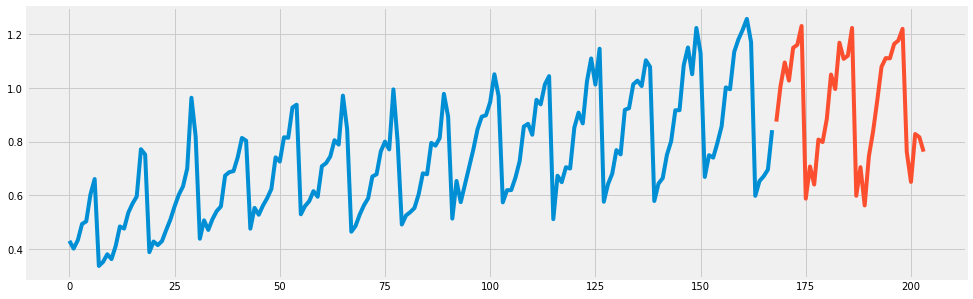

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

# Series temporales (5 puntos)
## 1.1 Componentes de la serie temporal (2.5 puntos)
### 1.1.a. Heterocedasticidad
Se dice que una serie temporal tiene heterocedasticidad cuando la variancia varía con el tiempo (https://es.wikipedia.org/wiki/Heterocedasticidad).

El correcto funcionamiento del modelo de regresión lineal está basado en el cumplimiento de una serie de hipótesis entre las que destacan las relacionadas con el error, que son:

El término error es completamente aleatorio y sigue una distribución normal, de esperanza 0. La varianza del error es constante a lo largo de las observaciones del modelo (Var[εi]=σ2). El término error no esta correlacionado entre los elementos del modelo y es independiente también de la variable explicativa. La heteroscedasticidad es un problema que surge con el incumplimiento de la segunda de estás hipótesis, la que implica que la varianza del error debe ser constante a lo largo de las observaciones.

En nuestro caso, observamos que tenemos heterocedasticidad, ya que la amplitud de onda varía con el tiempo. En este primer apartado debéis eliminar la heterocedasticidad de la serie temporal. Es decir, que la diferencia entre el mínimo y el máximo de la estacionalidad (anual) sea más o menos la misma a lo largo del tiempo.

**Ayuda**: Para saber qué transformación elimina mejor la heterocedasticidad, tenemos que ver tanto numéricamente como visualmente cuál de ellas presenta la menor varianza. 

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Transformación de los datos para eliminar la heterocedasticidad. Para hacer eso debeis transformar los datos aplicando la función que consideréis que elimina mejor la heterocedasticidad en el dataset (exponencial, logarítmica, ...). Estas funciones ya están implementadas en numpy. Graficar los datos originales junto con los datos transformados.
</div>

--------------------------------------------------------
Datos sin transformar
--------------------------------------------------------
Varianza de train: 0.04473075390018074
Varianza de test: 0.04267503376956093
Varianza total: 0.05043240998780437


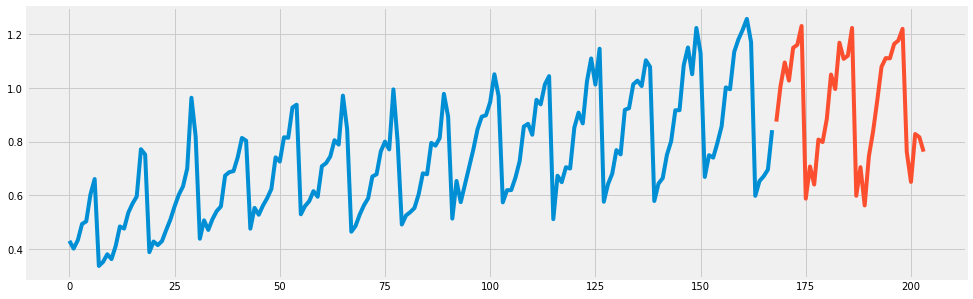

In [33]:
print("--------------------------------------------------------")
print("Datos sin transformar")
print("--------------------------------------------------------")
print("Varianza de train: " + str(np.var(train)))
print("Varianza de test: " + str(np.var(test)))
print("Varianza total: " + str(np.var(datos)))

TEST_SIZE = 36
train, test = datos.iloc[:-TEST_SIZE], datos.iloc[-TEST_SIZE:]
x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], datos.shape[0]))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)

--------------------------------------------------------
Datos transformados EXPONENCIAL
--------------------------------------------------------
Varianza de train: 0.22030709268844215
Varianza de test: 0.2729113771539326
Varianza total: 0.2626520022472048


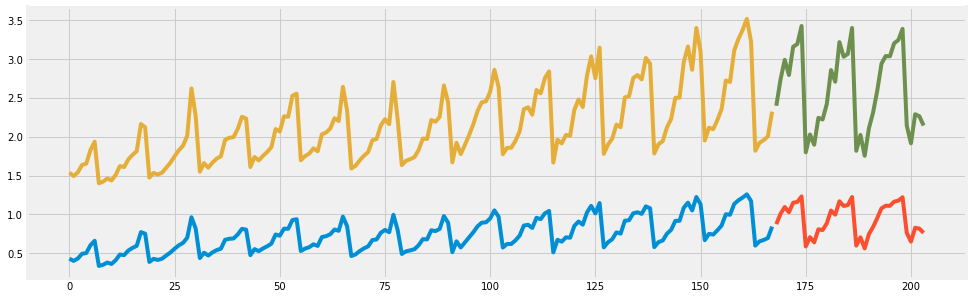

In [38]:
print("--------------------------------------------------------")
print("Datos transformados EXPONENCIAL")
print("--------------------------------------------------------")

datos_exp = np.exp(datos)
train_exp, test_exp = datos_exp.iloc[:-TEST_SIZE], datos_exp.iloc[-TEST_SIZE:]

print("Varianza de train: " + str(np.var(train_exp)))
print("Varianza de test: " + str(np.var(test_exp)))
print("Varianza total: " + str(np.var(datos_exp)))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)
ax.plot(x_train, train_exp)
ax.plot(x_test, test_exp)

--------------------------------------------------------
Datos transformados LOGARÍTMICA
--------------------------------------------------------
Varianza de train: 0.08719515799646181
Varianza de test: 0.054994000683095505
Varianza total: 0.0915169343390335


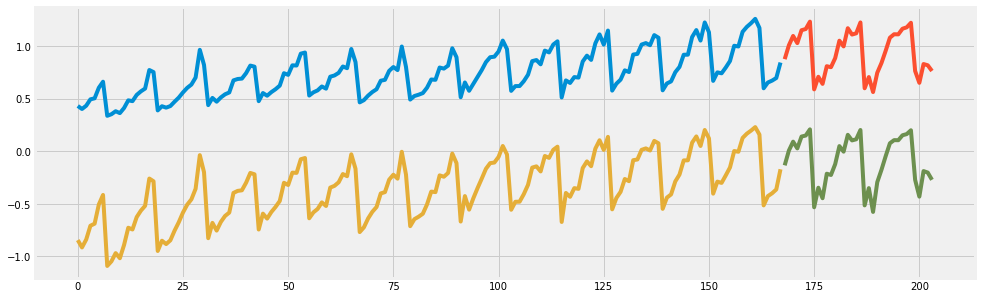

In [42]:
print("--------------------------------------------------------")
print("Datos transformados LOGARÍTMICA")
print("--------------------------------------------------------")

datos_log = np.log(datos)
train_log, test_log = datos_log.iloc[:-TEST_SIZE], datos_log.iloc[-TEST_SIZE:]

print("Varianza de train: " + str(np.var(train_log)))
print("Varianza de test: " + str(np.var(test_log)))
print("Varianza total: " + str(np.var(datos_log)))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)
ax.plot(x_train, train_log)
ax.plot(x_test, test_log)

Como podemos observar, la transformación logarítmica es la que mejor se comporta, es verdad que introduce algo más de variabilidad, es decir, la varianza es un poco mayor que en los datos originales, pero esto está bien ya que se busca una menor variabilidad anual no en toda la serie temporal. Por lo tanto, la trasformación logarítmica consigue que el mínimo y máximo anual se mantengan más o menos estables a lo largo del tiempo, mientras que la escala exponencial era todo lo contrario, introducía mucha variabilidad en toda la línea temporal.

### 1.1.b. Tendencia

La [tendencia](https://miro.medium.com/max/1872/1*rDQL2fAp_X_dgAHNZuwRfw.png) es el comportamento que tiene los datos a largo plazo. 

En nuestra serie temporal tenemos una tendencia lineal creciente. En este apartado debéis eliminar la tendencia, quedando una serie temporal con tendencia constante.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Eliminar la tendencia de los datos. Si observamos la serie podemos apreciar que tenemos una tendencia lineal, podemos ajustar una regresión lineal (usando scikit-learn) y sustraerla a los datos originales (sin heterocedasticidad). Graficar los datos con tendencia junto con los datos sin tendencia.
</div>

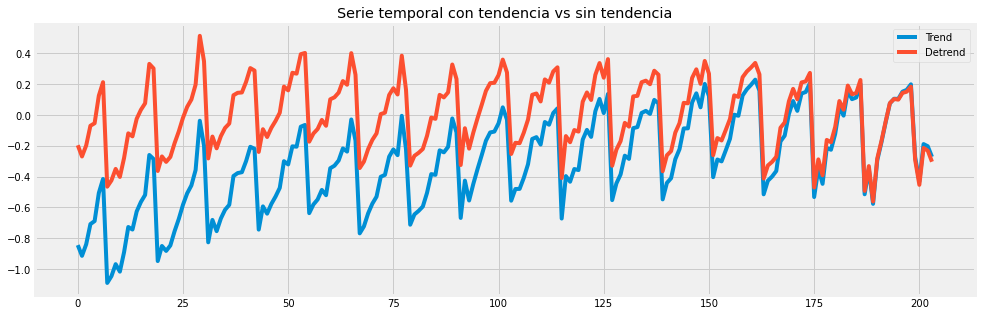

In [67]:
# Preparamos todo el conjunto de datos para el modelo de regresión lineal
X =  np.array(range(datos_log.shape[0]))
X = X.reshape(datos_log.shape[0], 1)
y = datos_log.values

# Creamos y ajustamos el modelo
model_lr = LinearRegression()
model_lr.fit(X, y)

# Predecimos los valores
y_pred = model_lr.predict(X)

# Eliminamos la tendencia
detrend = [y[i] - y_pred[i] for i in range(datos_log.shape[0])]

# Graficamos los datos con tendencia y sin tendencia
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(X, y)
ax.plot(X, detrend)
plt.title("Serie temporal con tendencia vs sin tendencia")
plt.legend(["Trend", "Detrend"])

### 1.1.c. Estacionalidad

Definimos [estacionalidad](https://analisisdedatos.net/analisis/ST/estacionariedad.php) como la variación cíclica que se produce en los datos. En este apartado se debe encontrar y eliminar la estacionalidad. 

#### 1.1.c.a. Encontrar el periodo de la estacionalidad

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> En primer lugar debeis encontrar el ciclo, es decir, cada cuando se repiten los datos. Para ello podemos usar la autocorrelación (numpy te permite obtener los coeficientes de correlación). Graficar los coeficientes para los 24 primeros valores de autocorrelación y determinar su valor máximo, está será nuestra estacionalidad. Dar una interpretación semántica del resultado obtenido.
</div>

#### 1.1.c.b. Aplicar un modelo SARIMA

Para tratar la estacionalidad aplicaremos un modelo SARIMA. Las siglas corresponden a "stationality ARIMA", es decir, un modelo ARIMA con estacionalidad (la que acabamos de encontrar).

El modelo [ARIMA](https://otexts.com/fpp2/arima.html) nos va a permitir tratar el ruido que queda al eliminar la heterocedasticidad, tendencia y estacionalidad. Para hacerlo tiene en cuenta las siguientes componentes:

- AR: auto-regressive, se denomina *p*. Tiene en cuenta la correlación con sus lags, es decir, mira si las observaciones pasadas afectan para calcular el siguiente punto. 
- I: integrated, se denomina *d*. Es el orden de diferenciación, en nuestro caso no es necesario, puesto que la serie ya no tiene heterocedasticidad ni tendencia. Por lo tanto nuestra *d* = 0
- MA: moving-average, se denomina *q*. Tiene en cuenta la correlación con los lags de los errores, es decir, una vez se ha aplicado el modelo, mira los errores del modelo versus los datos reales.

Los modelos SARIMA dependen de varios parámetros (p,d,q)(P,D,Q)s, donde los primeros (minúsculas) corresponden a AR, I, MA de la serie normal, u los segundos (mayúsculas) a AR, I, MA con estacionalidad. 

Para encontrar estos parámetros tenemos que mirar los gráficos PACF (<i>partial autocorrelation function</i>) y ACF (<i>autocorrelation function</i>).

El gráfico PACF nos determina el parámetro *p*, es decir, la AR.

Vamos a describir cada una de las partes: 

#### ¿Qué entendemos por autocorrelación en las series temporales?
Es un término estadístico que se utiliza para describir la presencia o ausencia de correlación en los datos de las series temporales, indicando, si las observaciones pasadas influyen en las actuales.

Por tanto, se puede decir que la autocorrelación hace referencia cuando los valores que toman una variable en el tiempo no son independientes entre sí, sino que un valor determinado depende de los valores anteriores.

El problema de la autocorrelación se denomina también frecuentemente de **“correlación serial”**.

Para medir la autocorrelación se suele usar:


La **función de autocorrelación (ACF)**:
- Mide la correlación entre dos variables separadas por k periodos.
- Mide el grado de asociación lineal que existe entre dos variables del mismo proceso estocástico.

La **función de autocorrelación parcial (PACF)**
- Mide la correlación entre dos variables separadas por k periodos cuando no se considera la dependencia creada por los retardos intermedios existentes entre ambas.
- Mide la autocorrelación que existe entre dos variables separadas k períodos descontando los posibles efectos debidos a variables intermedias.

Por lo tanto, la función ACF es usada para identificar el proceso de media móvil (MA) en un modelo ARIMA; mientras que la función PACF se usa para identificar los valores de la parte del proceso autoregresivo (AR).

Los gráficos generados a partir de estas funciones se denominan **correlogramas**, los cuales contienen bandas con un intervalo de confianza del 95%.

In [ ]:
# Supongamos que los datos sin heterocedasticidad ni tendencia se llaman train_sqrt_trend
plot_pacf(train_sqrt_trend)
plt.show()

Para leer este gráfico, simplemente nos tenemos que fijar en los valores que salen fuera del intervalo de confianza (zona azul).

Nada mas empezar hay dos valores fuera del intervalo. De todos modos el primero no se debe tener en cuenta, puesto que mira la correlación de un valor consigo mismo (lag0), y esta siempre será 1. Si no tenemos en cuenta este primer valor, solo hay un valor fuera del intervalo de confianza antes de que éste cambie de signo, con lo cual p = 1.

Cuando se repite el ciclo, es decir, a partir del valor 12 (recordemos que éste es el lag11, vuelve a haber un valor fuera del intervalo antes de que éste cambie de signo, con lo cual P = 2.

Veamos ahora el gráfico ACF, este determinará el valor de q.

In [ ]:
# Supongamos que los datos sin heterocedasticidad ni tendencia se llaman train_sqrt_trend
plot_acf(train_sqrt_trend)
plt.show()

Este gráfico se lee igual que el anterior. Nada más empezar hay dos valores fuera del intervalo (recordemos que el lag0 no lo contamos), con lo cual q = 2. Cuando se repite el ciclo, es decir, a partir del valor 11, hay dos valores fuera del intervalo, con lo cual Q = 2.

Como los datos no tienen ni tendencia ni heterocedasticidad (se la hemos quitado en apartados anteriores), d = D = 0.

Como hemos visto en el apartado anterior, el ciclo es 12, con lo cual s = 12.

## 1.2 Predicciones


<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Aplica un modelo SARIMA a los datos sin heterocedasticidad ni tendencia. Puedes usar SARIMAX (de <i>statsmodels.tsa.statespace.sarimax</i>) con los parámetros que acabamos de ver. 
    
Mostrar gráficamente el resultado del modelo junto con la serie original para comparar si se ajusta bien.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Comenta los resultados que te han salido del modelo SARIMAX
</div>

### 1.2.a. Predicción SARIMA (2.5 puntos)

Utilizaremos el modelo SARIMA que hemos filtrado antes para predecir los tres próximos años (que son los años que hemos quitado anteriormente).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Genera tres años de datos predichos mediante el modelo SARIMA realizado en el apartado anterior.

Grafica toda la serie (sin heterocedasticidad ni tendencia), diferenciando con colores diferentes la serie real de los tres años de predicción.
</div>

### 1.2.b. Tendencia

Anteriormente hemos visto que los datos de la serie temporal tienen una tendencia lineal y la hemos calculado mediante una regresión lineal. Vamos a añadir esta tendencia a nuestra predicción.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Añadir a la serie anterior, la tendencia encontrada en el apartado 1.1.b.

Mostrar gráficamente toda la serie (sin heterocedasticitat), diferenciando con colores diferentes la serie real de los dos años de predicción.
</div>

### 1.2.c. Heterocedasticidad

En el primer apartado de esta práctica hemos visto que la serie temporal tiene heterocedasticidad y la hemos eliminado transformando los datos. En este apartado haremos la transfromación inversa para añadir heterocedasticidad a nuestra predicción.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Añadir a la serie anterior, la heterocedasticidad aplicando la función inversa a la encontrada en el apartado 1.1.a.
    
Mostrar gráficamente toda la serie, diferenciando con colores diferentes la serie real de los años de predicción. 
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Añade al gráfico anterior los datos de test para ver si coinciden con la predicción.
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Calcula el error cometido en test (por ejemplo calcula el MSE).


</div>

## 2. Combinación de clasificadores (5 puntos)

El ensemble learning es una estrategia en la que se utiliza un grupo de modelos para resolver un problema  mediante la combinación estratégica de diversos modelos de aprendizaje automático en un solo modelo predictivo. 

En general, los métodos de ensemble se utilizan principalmente para mejorar la precisión del rendimiento general de un modelo y combinar varios modelos diferentes, también conocidos como *aprendices básicos*, para predecir los resultados, en lugar de utilizar un solo modelo.

¿Por qué entrenamos tantos clasificadores diferentes en lugar de uno solo? Bueno, el uso de varios modelos para predecir el resultado final en realidad reduce la probabilidad de sopesar las decisiones tomadas por modelos deficientes (sobreentrenados, no debidamente ajustados...).

Cuanto más diversos sean estos aprendices básicos, más poderoso será el modelo final. 

Tengamos en cuenta que en cualquier modelo de aprendizaje automático, el error de generalización viene dado por la suma de cuadrados de bias + varianza + error irreductible. 

¡Los errores irreductibles son algo que está más allá de nosotros! No podemos reducirlos. 

Sin embargo, utilizando ensembles, podemos reducir el sesgo (bias) y la varianza de un modelo. Esto reduce el error de generalización general.

La **compensación de sesgo-varianza** es el punto de referencia más importante que diferencia un modelo robusto de uno inferior (entendamos por inferior un modelo no demasiado generalizable). 

Aunque no es una regla exacta, en el aprendizaje automático, los modelos que tienen un sesgo alto tienden a tener una varianza más baja y viceversa.

Hemos estado hablando de bias y varianza. Pero veamos que entendemos por sesgo de un modelo y por varianza de un modelo. 

1. **Sesgo**: El sesgo es un error que surge debido a suposiciones falsas realizadas en la fase de aprendizaje de un modelo. Un sesgo alto puede hacer que un algoritmo de aprendizaje omita información importante y correlaciones entre las variables independientes y las etiquetas de clase, por lo que no se ajusta al modelo.

2. **Varianza**: la varianza nos dice qué tan sensible es un modelo a los pequeños cambios en los datos de entrenamiento. Es decir, cuánto cambia el modelo. Una gran variación en un modelo lo hará propenso al ruido aleatorio presente en el conjunto de datos, por lo que se ajustará demasiado al modelo.

Para comprender con más detalle la compensación de sesgo y varianza en los modelos de aprendizaje automático, podeís consultar este [artículo](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229). 


Una vez llegados a este punto, podemos dividir los ensembles en cuatro categorías: 

1. **Bagging**: El bagging se utiliza principalmente para reducir la variación en un modelo. Un ejemplo simple de bagging es el algoritmo Random Forest.

2. **Boosting**: El boosting se utiliza principalmente para reducir el sesgo en un modelo. Ejemplos de algoritmos de impulso son Ada-Boost, XGBoost, árboles de decisión mejorados por gradiente, etc.

3. **Stacking**: el stacking se utiliza principalmente para aumentar la precisión de predicción de un modelo. Para implementar el stacking usaremos la biblioteca mlextend proporcionada por scikit learn.

4. **Cascading**: esta clase de modelos son muy precisos. La conexión en cascada se usa principalmente en escenarios en los que no puede permitirse cometer un error. Por ejemplo, una técnica en cascada se usa principalmente para detectar transacciones fraudulentas con tarjetas de crédito.

## Datos

Para este ejercicio usaremos el dataset *diabetes.csv*.  Este conjunto de datos es original del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. El objetivo de este dataset es predecir basándose en las mediciones de diagnóstico si un paciente tiene diabetes.

En particular, todos los pacientes aquí son mujeres de al menos 21 años de ascendencia india Pima.

El dataset contiene la siguiente información

Embarazos: número de embarazos
Glucosa: concentración de glucosa en plasma a 2 horas en una prueba de tolerancia a la glucosa oral
Presión arterial: presión arterial diastólica (mm Hg)
SkinThickness: Espesor del pliegue cutáneo del tríceps (mm)
Insulina: insulina sérica de 2 horas (mu U / ml)
IMC: índice de masa corporal (peso en kg / (altura en m) ^ 2)
DiabetesPedigreeFunction: función del pedigrí de la diabetes
Edad: Edad (años)
Resultado (variable objetivo): variable de clase (0 o 1) 

En la primera parte de este ejercicio veremos la combinación de clasificadores en paralelo mediante las tecnicas de 
**_Bagging_** y **_Boosting_**.

En la segunda parte intentaremos mejorar los resultados aplicando tecnicas de combinación secuencial de clasificadores: **_Stacking_** y **_Cascading_**.

Para empezar, veamos como es el dataset.

In [ ]:
diabetes = pd.read_csv('diabetes.csv')

nRow, nCol = diabetes.shape
print(f'Hay {nRow} filas y {nCol} columnas')
diabetes.tail()

Para poder probar varios modelos, primero vamos a dividir el dataset entre train y test.

Para que todos obtengáis los mismos resultados y poder comentar dudas por el foro, fijaremos la seed para obtener los mismos datasets de train y test.

Como en este ejercicio trataremos *stacking* y *cascading*, y ambos se aplican sobre el conjunto de test, haremos un *split* del 60% para tener un poco más de base al aplicar estas dos técnicas.

In [ ]:
myseed= 38
X = diabetes.drop(columns = 'Outcome')
y = diabetes['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=myseed)

## 2.1. Combinación paralela de clasificadores (2 puntos)

### 2.1.1. Árboles de decisión

Para poder comparar el aumento de  *performance* obtenido a medida que vamos aplicando técnicas nuevas, utilizaremos como  *baseline* un simple árbol de decisión.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Entrena un árbol de decisión sobre el conjunto de datos de train con profundidad máxima de 3 niveles (aplicaremos la misma restricción en las siguientes secciones).
    
A continuación evalua sobre test y calcula su precisión aplicando validación cruzada con 5 conjuntos.
   
    
<u>Sugerencia</u>: usar el módulo [*cross_val_score*](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) de *sklearn*. Para aprender más sobre [*cross validation](http://scikit-learn.org/stable/modules/cross_validation.html) y sobre como usar estos módulos, os recomendamos los siguientes enlaces: 
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Analizad los resultados obtenidos 
</div>

### 2.1.2.a. *Bagging*

La idea central del bagging es usar réplicas del conjunto de datos original y usarlas para entrenar diferentes clasificadores.

Crearemos subconjuntos muestreando aleatoriamente un montón de puntos del conjunto de datos de entrenamiento con reemplazo. 

Ahora entrenaremos clasificadores individuales en cada uno de estos subconjuntos bootstrap. 

Cada uno de estos clasificadores base predecirá la etiqueta de clase para un problema dado. Aquí es donde combinamos las predicciones de todos los modelos base. Esta parte se llama etapa de agregación. Es por eso que encontraréis los ensembles bagging por el nombre de ensembles de agregación. 

Por lo general, se usa un voto de mayoría simple en un sistema de clasificación y se toma la media de todas las predicciones para los modelos de regresión para combinar todos los clasificadores base en un solo modelo y proporcionar el resultado final del modelo de conjunto. 

Un ejemplo simple de tal enfoque es el algoritmo Random Forest. El bagging reduce la alta variación (varianza) de un modelo, reduciendo así el error de generalización. Es un método muy eficaz, especialmente cuando tenemos datos muy limitados con pudiera ser nuestro caso. 

Mediante el uso de muestras de bootstrap, podemos obtener una estimación agregando las puntuaciones de muchas muestras.




**¿Cómo haríamos el bagging?**

Supongamos que tenemos un conjunto de entrenamiento que contiene 100.000 puntos de datos. 

Crearíamos N subconjuntos muestreando al azar 50K puntos de datos para cada subconjunto. 

Cada uno de estos N subconjuntos se utilizará para entrenar N clasificadores diferentes. 

En la etapa de agregación, todas estas N predicciones se combinarán en un solo modelo, también llamado metaclasificador. 

De los 100.000 puntos presentes originalmente en el conjunto de datos, si eliminamos 1000 puntos, el impacto que tendrá en los conjuntos de datos muestreados será muy inferior. 

Si pensamos intuitivamente, es posible que algunos de estos 1000 puntos no estén presentes en todos los conjuntos de datos muestreados y, por lo tanto, la cantidad de puntos que se eliminarán de cada conjunto de datos muestreados será muy inferior. ¡Incluso cero en algunos casos! En resumen, el impacto de eliminar 1000 puntos de este tipo será en realidad menor en los clasificadores base, lo que reducirá la variación en un modelo y lo hará más sólido. 

La varianza no es más que sensibilidad al ruido, como hemos comentado anteriormente.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Entrena un <i>random forest</i> sobre el conjunto de datos de train con <b>20 árboles</b> de decisión y <b>profundidad máxima de 3</b> niveles.
    
A continuación evalua sobre test y calcula su precisión aplicando validación cruzada con 5 conjuntos.



<u>Sugerencia</u>: usar el módulo [*RandomForestClassifier*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) de *sklearn*. Per apender a usar este módulo os recomendamos el siguiente enlace:
</div>

### 2.1.2.b. *Boosting*

El boosting se utiliza para convertir a los clasificadores de base débil en fuertes. Los clasificadores débiles generalmente tienen una correlación muy débil con las etiquetas de clase verdaderas y los clasificadores fuertes tienen una correlación muy alta entre el modelo y las etiquetas de clase verdaderas.

El boosting capacita a los clasificadores débiles de manera iterativa, cada uno tratando de corregir el error cometido por el modelo anterior. Esto se logra entrenando un modelo débil en todos los datos de entrenamiento, luego construyendo un segundo modelo que tiene como objetivo corregir los errores cometidos por el primer modelo. Luego construimos un tercer modelo que intenta corregir los errores cometidos por el segundo modelo y así sucesivamente. Los modelos se agregan de forma iterativa hasta que el modelo final ha corregido todos los errores cometidos por todos los modelos anteriores.

Cuando se agregan los modelos en cada etapa, se asignan algunos pesos al modelo que está relacionado con la precisión del modelo anterior. Después de agregar un clasificador débil, los pesos se vuelven a ajustar. Los puntos clasificados incorrectamente reciben pesos más altos y los puntos clasificados correctamente reciben pesos más bajos. Este enfoque hará que el siguiente clasificador se centre en los errores cometidos por el modelo anterior.

El boosting reduce el error de generalización tomando un modelo de alto bias y baja varianza y reduciendo el bias en un nivel significativo. Recuerde, el bagging reduce la varianza. Al igual que el bagging, el boosting también nos permite trabajar con modelos de clasificación y regresión. 

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Entrena un gradient boosting sobre el conjunto de datos de train con 20 árboles de decisión y profundidad máxima de 3 niveles. A continuación evalua sobre test y calcula su precisión aplicando validación cruzada con 5 conjuntos. Finalmente, dibuja la frontera de decisión. 

Sugerencia: usar el módulo [*GradientBoostingClassifier*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) de sklearn. 
</div> 

## 2.2. Combinación secuencial de clasificadores base diferentes (3 puntos)

Para poder hacer combinación secuencial de modelos, necessitamos tener varios modelos diferentes entrenados. 

En nuestro caso, ya tenemos un árbol de decisión. Vamos a entrenar un par de modelos más.

### 2.2.1 KNN (k vecinos más próximos)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Entrena un <i>k-neighbors</i> con 2 vecinos sobre el conjunto de datos de train.  

A continuación evalua sobre test y calcula su precisión aplicando validación cruzada con 5 conjuntos.
</div>  

### 2.2.1 SVM (Support Vector Machines)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Entrena un SVM con gamma = 0.07 sobre el conjunto de datos de train.

A continuación evalua sobre test y calcula su precisión aplicando validación cruzada con 5 conjuntos.
</div>  

### 2.2.1 *Stacking*
Todos los modelos individuales se entrenan por separado en el conjunto completo de datos de entrenamiento y se ajustan para lograr una mayor precisión. La compensación de bias y varianza se tiene en cuenta para cada modelo. El modelo final, también conocido como metaclasificador, se alimenta de las etiquetas de clase predichas por los modelos base o de las probabilidades predichas para cada etiqueta de clase. Luego, el metaclasificador se entrena en función de los resultados dados por los modelos base. 

En el stacking, se entrena un nuevo modelo en función de las predicciones realizadas por los modelos anteriores.
Este proceso se lleva a cabo de forma secuencial. Esto significa que varios modelos se entrenan en la etapa 1 y se ajustan con precisión. Las probabilidades pronosticadas de cada modelo de la etapa 1 se alimentan como entrada a todos los modelos en la etapa 2. Los modelos en la etapa 2 luego se ajustan con precisión y las salidas correspondientes se alimentan a los modelos en la etapa 3 y así sucesivamente. Este proceso se produce varias veces en función de la cantidad de capas de apilamiento que desee utilizar.

La etapa final consiste en un único modelo que nos da el resultado final al combinar el resultado de todos los modelos presentes en las capas anteriores. 

A menudo, el uso de clasificadores apilables aumenta la precisión de predicción de un modelo. ¡Pero de ninguna manera puede garantizarse que el uso de apilamiento aumente la precisión de la predicción en todo momento!
Echad un vistazo al siguiente [link](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Construye un clasificador de <i>stacking</i> usando un <i>Gradient Boosting</i> (con <b>20 árboles</b> de decisión y <b>profundidad máxima de 3</b> niveles) que use como atributos las predicciones hechas en el conjunto de test por los algoritmos: 
    
- árbol de decisión
- knn
- svm 
 
Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test (en este caso no tenemos conjunto de train, con lo cual se hace directamente cross-validation sobre test).

<u>Sugerencia</u>: usar la función [column_stack](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.column_stack.html) de numpy para juntar todas las predicciones. 
</div>

<div class="alert alert-block alert-info">
    <strong>Análisis:</strong> ¿Has conseguido mejorar la precisión gracias al <i>stacking</i>? Comenta los resultados.
</div>

### 2.2.2. *Cascading*

El caso de cascading es parecido al de stacking pero utilizando no solamente las predicciones parciales de los clasificadores base, sino también los datos originales.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> Para ello construimos un clasificador de cascading usando un Gradient Boosting (con 20 árboles de decisión y profundidad máxima de 3 niveles) que use como atributos las predicciones obtenidas con los modelos anteriores en el conjunto de test (igual que con el stacking), y también las variables originales. 
Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test. Sugerencia: Usa el mismo conjunto de datos que en el ejercicio anterior pero añade `X_test`.
</div>


<div class="alert alert-block alert-info">
    <strong>Análisis:</strong> Has conseguido mejorar la precisión gracias al <i>cascading</i>? Comenta los resultados.
</div>

# Bibliografía utilizada

- [Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia](https://otexts.com/fpp3/) 

- [Time Series Analysis and Forecasting with ADAM Ivan Svetunkov](https://openforecast.org/adam/)

- [Python Data Science Handbook by Jake VanderPlas](https://www.amazon.es/gp/product/1491912057/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1491912057&linkId=73620d22f9d4a0a76d27592dabf13c83) 

- [Python for Finance: Mastering Data-Driven Finance](https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055) 

In [ ]:
import session_info
session_info.show(html=False)